SF Crime Classification


Project Setup

Kaggle SF Crime problem: https://www.kaggle.com/c/sf-crime
Includes some data exploration, models and analysis



In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
#from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *


In [3]:
Location = r'C:\Users\bhushanr\Downloads\data\train.csv'
Location1 = r'C:\Users\bhushanr\Downloads\data\test.csv'

data = pd.read_csv(Location)
test_data = pd.read_csv(Location1)
data.shape

#print data fields
print(data.columns)



Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y'],
      dtype='object')


In [4]:
#Clean variables
data['Dates'] = pd.to_datetime(data['Dates'])
data['Year'] = data.Dates.dt.year
data['Month'] = data.Dates.dt.month
data['Day'] = data.Dates.dt.month
data['Date'] = data.Dates.dt.day
data['Hour'] = data.Dates.dt.hour
data['DayOfYear'] = data.Dates.dt.dayofyear
data.dtypes

Dates         datetime64[ns]
Category              object
Descript              object
DayOfWeek             object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
Year                   int64
Month                  int64
Day                    int64
Date                   int64
Hour                   int64
DayOfYear              int64
dtype: object

In [5]:
# Count distinct for each variable:
print("There are a total of {:,}, values.".format(len(data)))

for var, series in data.iteritems():
    print("There are a total of {:,} {}.".format(len(series.value_counts()), var))

There are a total of 878,049, values.
There are a total of 389,257 Dates.
There are a total of 39 Category.
There are a total of 879 Descript.
There are a total of 7 DayOfWeek.
There are a total of 10 PdDistrict.
There are a total of 17 Resolution.
There are a total of 23,228 Address.
There are a total of 34,243 X.
There are a total of 34,243 Y.
There are a total of 13 Year.
There are a total of 12 Month.
There are a total of 12 Day.
There are a total of 31 Date.
There are a total of 24 Hour.
There are a total of 338 DayOfYear.


In [6]:
# View All of Categories, PdDistrict, Resolution, DayOfWeek
variables = ["Category", "PdDistrict", "DayOfWeek","Month","Day","Hour"]
for col in variables:
    print("-------------------------------------------------------------------------")
    print("There are a total of {:,} distinct {} values, as follows: ".format(len(data[col].value_counts()), col))
    print(data[col].value_counts())
    print()

-------------------------------------------------------------------------
There are a total of 39 distinct Category values, as follows: 
LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE          

In [7]:
print(data.describe())

                   X              Y           Year          Month  \
count  878049.000000  878049.000000  878049.000000  878049.000000   
mean     -122.422616      37.771020    2008.712046       6.436509   
std         0.030354       0.456893       3.631194       3.428972   
min      -122.513642      37.707879    2003.000000       1.000000   
25%      -122.432952      37.752427    2006.000000       3.000000   
50%      -122.416420      37.775421    2009.000000       6.000000   
75%      -122.406959      37.784369    2012.000000       9.000000   
max      -120.500000      90.000000    2015.000000      12.000000   

                 Day           Date           Hour      DayOfYear  
count  878049.000000  878049.000000  878049.000000  878049.000000  
mean        6.436509      15.570623      13.412655     180.332158  
std         3.428972       8.783005       6.549573     104.897857  
min         1.000000       1.000000       0.000000       1.000000  
25%         3.000000       8.000000   

In [8]:
outlier = data[data.Y == 90]
print("There are {} outliers where Y == 90".format(len(outlier)))
print("Save the outliers separately and removed from plotting")
train_data = data[data.Y != 90]

There are 67 outliers where Y == 90
Save the outliers separately and removed from plotting


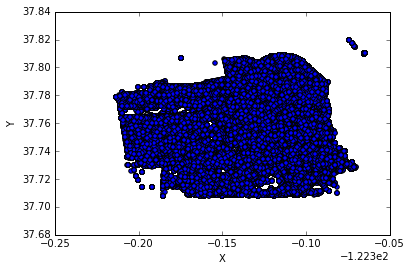

In [9]:
#Make a basic plot
train_data.plot(kind='scatter', x='X', y='Y')

In [11]:
#Create a function to make a submission to kaggle

def create_kaggle_submission(preds):
    labels = ["Id", "ARSON", "ASSAULT", "BAD CHECKS", "BRIBERY", "BURGLARY", "DISORDERLY CONDUCT", "DRIVING UNDER THE INFLUENCE", 
             "DRUG/NARCOTIC", "DRUNKENNESS", "EMBEZZLEMENT", "EXTORTION", "FAMILY OFFENSES", "FORGERY/COUNTERFEITING", "FRAUD",
             "GAMBLING","KIDNAPPING","LARCENY/THEFT","LIQUOR LAWS","LOITERING","MISSING PERSON","NON-CRIMINAL",
              "OTHER OFFENSES","PORNOGRAPHY/OBSCENE MAT","PROSTITUTION","RECOVERED VEHICLE","ROBBERY","RUNAWAY",
              "SECONDARY CODES","SEX OFFENSES FORCIBLE","SEX OFFENSES NON FORCIBLE","STOLEN PROPERTY","SUICIDE",
              "SUSPICIOUS OCC","TREA","TRESPASS","VANDALISM","VEHICLE THEFT","WARRANTS","WEAPON LAWS"]
    head_str = ','.join(labels)
    num_cat = len(labels)
    
    ids = np.arange(preds.shape[0])[np.newaxis].transpose()
    results = np.column_stack((ids,preds))
    
    num_form = ['%4f']*(num_cat - 1)
    num_form.insert(0, '%d')
    
    np.savetxt('sample.csv', results, fmt=num_form, delimiter=',', header=head_str,comments='')
    

Bernouilli Naive Bayes

Feature generation
Bernouilli NB requires binary data so create dummy variables for each variable in the data set.

In [12]:
Location = r'C:\Users\bhushanr\Downloads\data\train.csv'
Location1 = r'C:\Users\bhushanr\Downloads\data\test.csv'
data_orig = pd.read_csv(Location)
test_orig = pd.read_csv(Location1)

# Extract new features in Pandas
def time_features(data):
    data['DateTime'] = pd.to_datetime(data['Dates'])
    data['Year'] = pd.DatetimeIndex(data['DateTime']).year
    data['Month'] = pd.DatetimeIndex(data['DateTime']).month
    data['Day'] = pd.DatetimeIndex(data['DateTime']).day
    data['Hour'] = pd.DatetimeIndex(data['DateTime']).hour
    data['SecondsDelta'] = (data.DateTime - pd.Timestamp('2013-01-01')) / np.timedelta64(1,'s')
    data['Weekend'] = (data.DayOfWeek == "Saturday") | (data.DayOfWeek == "Sunday")
    years = pd.get_dummies(data.Year)
    months = pd.get_dummies(data.Month)
    months.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    days = pd.get_dummies(data.Day)
    daysofweek = pd.get_dummies(data.DayOfWeek)
    hours = pd.get_dummies(data.Hour)
    hours.columns = ['12AM', '1AM', '2AM', '3AM', '4AM', '5AM',
                     '6AM', '7AM', '8AM', '9AM', '10AM', '11AM',
                     '12PM', '1PM', '2PM', '3PM', '4PM', '5PM',
                     '6PM', '7PM', '8PM', '9PM', '10PM', '11PM']
    districts = pd.get_dummies(data.PdDistrict)
    new_data = pd.concat([data, years, months, days, daysofweek, hours, districts], axis=1)
    return new_data

data = time_features(data_orig)
test = time_features(test_orig)

# Separate labels
labels = data.Category

# Drop Category, Descript and Resolution columns since we cannot use them to predict
train_data = data.drop(['Category', 'Descript', 'Resolution'], axis=1)
train_names = data.columns.values.tolist()
test_names = test.columns.values.tolist()
print(data.columns.values)

['Dates' 'Category' 'Descript' 'DayOfWeek' 'PdDistrict' 'Resolution'
 'Address' 'X' 'Y' 'DateTime' 'Year' 'Month' 'Day' 'Hour' 'SecondsDelta'
 'Weekend' 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 'Jan' 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sep' 'Oct' 'Nov' 'Dec' 1
 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 'Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday'
 'Wednesday' '12AM' '1AM' '2AM' '3AM' '4AM' '5AM' '6AM' '7AM' '8AM' '9AM'
 '10AM' '11AM' '12PM' '1PM' '2PM' '3PM' '4PM' '5PM' '6PM' '7PM' '8PM' '9PM'
 '10PM' '11PM' 'BAYVIEW' 'CENTRAL' 'INGLESIDE' 'MISSION' 'NORTHERN' 'PARK'
 'RICHMOND' 'SOUTHERN' 'TARAVAL' 'TENDERLOIN']


In [17]:
# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to features.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.

shuffle = np.random.permutation(np.arange(train_data.shape[0]))
train_data = train_data.reindex(shuffle)
labels = labels.reindex(shuffle)

# Remove records where Y == 90
train_data_clean = train_data[train_data.Y != 90]
labels_clean = labels[train_data.Y != 90]
num_examples = train_data_clean.shape[0]

# Split the feature and label sets into train and dev sets
mini_train_data = train_data_clean[:10000]
mini_train_labels = labels_clean[:10000]
reg_train_data = train_data_clean[10000:int(num_examples/2)]
reg_train_labels = labels_clean[10000:int(num_examples/2)]
dev_data = train_data_clean[int(num_examples/2):]
dev_labels = labels_clean[int(num_examples/2):]

test_data = test.copy()

print("Mini Train Data:", mini_train_data.shape)
print("Mini Train Labels:", mini_train_labels.shape)
print("Mini Train Unique Labels:", len(mini_train_labels.unique()))
print("\nRegular Train Data:", reg_train_data.shape)
print("Regular Train Labels:", reg_train_labels.shape)
print("Regular Train Unique Labels:", len(reg_train_labels.unique()))
print("\nDev Data:", dev_data.shape)
print("Dev Labels:", dev_labels.shape)
print("Dev Train Unique Labels:", len(dev_labels.unique()))
print("\nTest Data:", test_data.shape)
print("\nColumns in use:", train_names)


Mini Train Data: (10000, 110)
Mini Train Labels: (10000,)
Mini Train Unique Labels: 37

Regular Train Data: (428991, 110)
Regular Train Labels: (428991,)
Regular Train Unique Labels: 38

Dev Data: (438991, 110)
Dev Labels: (438991,)
Dev Train Unique Labels: 39

Test Data: (884262, 111)

Columns in use: ['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'DateTime', 'Year', 'Month', 'Day', 'Hour', 'SecondsDelta', 'Weekend', 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', '12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', 

In [13]:
features_to_use = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 
                   'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 
                   1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 
                   16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 
                   'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 
                   '12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', 
                   '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', 
                   'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 
                   'SOUTHERN', 'TARAVAL', 'TENDERLOIN', 'X', 'Y']

print("Number of features:", len(features_to_use))

Number of features: 99


Best parameter:
 {'alpha': 1.0}

Best score:
 2.56695897479


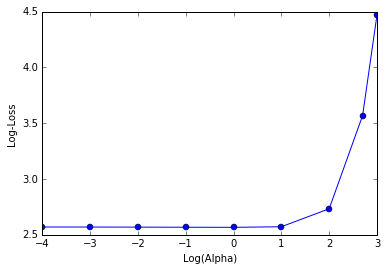

In [ ]:
# Calculate the optimal alpha is for a Bernoulli NB model

params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 500.0, 1000.0]}

clf = GridSearchCV(BernoulliNB(), [params], scoring='log_loss')
clf.fit(reg_train_data[features_to_use], reg_train_labels)

print("Best parameter:\n", clf.best_params_)
print("\nBest score:\n", -1 * clf.best_score_)

best_alpha = clf.best_params_['alpha']

scores = [clf.grid_scores_[i][1] * -1 for i in range(len(clf.grid_scores_))]

plt.plot(np.log10(params['alpha']), scores, marker='o')
plt.xlabel("Log(Alpha)")
plt.ylabel("Log-Loss")
plt.show()